In [2]:
import torch
import os
from transformers import *
import sys
import pickle
import pandas as pd
import numpy as np
import re
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import LabelEncoder
from torch.optim import optimizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss,BCEWithLogitsLoss
from tqdm import tqdm_notebook, trange
from sklearn.metrics import precision_recall_curve,classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
HOME_DIR = "/root/pro"
models_dir = os.path.join(HOME_DIR, 'models')
BERT_USING = 'chinese_rbtl3_pytorch'
model_dir = os.path.join(models_dir, BERT_USING)

In [4]:
#Load Data...
data = pd.read_excel('./data.xlsx',usecols=[1,2])
data.columns = ['text','label']
data

,text,label
0,8. 胰腺炎病史,Disease
1,3、孕妇。,Pregnancy-related Activity
2,11、既往有脑积水、脑室腹腔分流术或三脑室底造瘘及终板造瘘术病史。,Skip
3,1、孕妇和哺乳期妇女,Pregnancy-related Activity
4,（4）高血压,Disease
5,1. 15&gt;GFR≤60,Laboratory Examinations
6,(2) Foetal malpresentation contraindicating v...,Skip
7,4.窦性心律；,Sign
8,1、窦性心动过缓,Sign
9,9.在服用研究药物前28 天服用了任何改变肝酶活性的药物。,Skip


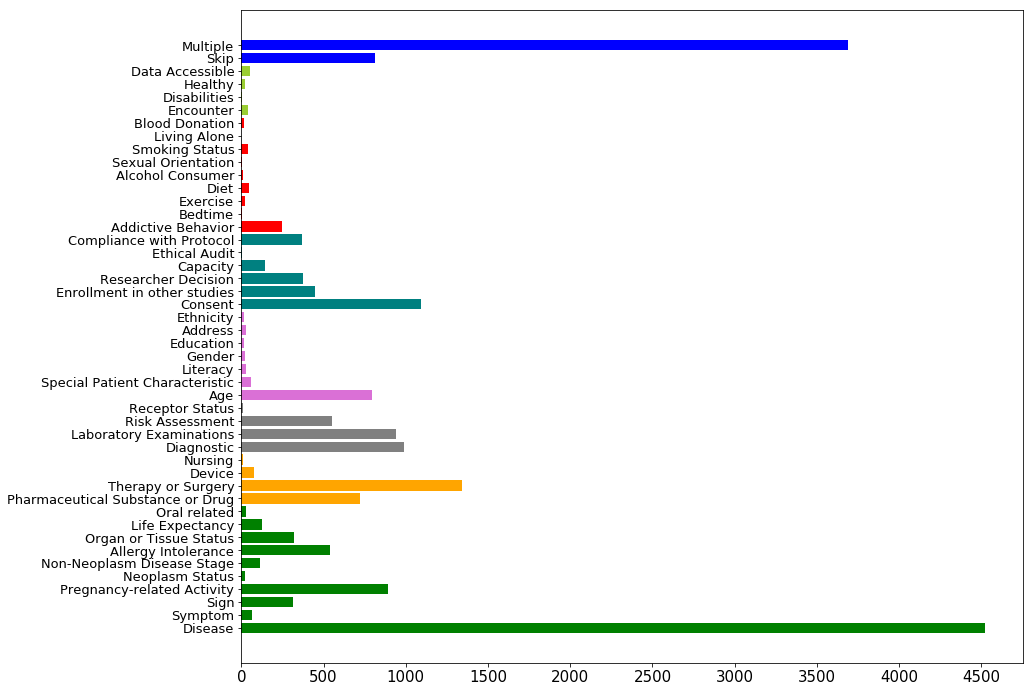

In [5]:
def labelSnapShot(data):
    
    LABEL_GROUPS = {'Health Status':['Disease', 'Symptom', 'Sign', 'Pregnancy-related Activity', 
'Neoplasm Status', 'Non-Neoplasm Disease Stage', 'Allergy Intolerance', 'Organ or Tissue Status', 
'Life Expectancy', 'Oral related'],

'Treatment or Health Care': ['Pharmaceutical Substance or Drug', 'Therapy or Surgery', 'Device', 'Nursing'],

'Diagnostic or Lab Test':['Diagnostic', 'Laboratory Examinations', 'Risk Assessment', 'Receptor Status'],

'Demographic Characteristics':['Age', 'Special Patient Characteristic', 'Literacy', 'Gender', 
'Education', 'Address', 'Ethnicity'],

'Ethical Consideration':['Consent', 'Enrollment in other studies', 'Researcher Decision', 'Capacity', 'Ethical Audit', 
'Compliance with Protocol'],

'Lifestyle Choice':['Addictive Behavior', 'Bedtime', 'Exercise', 'Diet', 'Alcohol Consumer', 
'Sexual Orientation', 'Smoking Status', 'Living Alone', 'Blood Donation'],

'Data or Patient Source':['Encounter', 'Disabilities', 'Healthy', 'Data Accessible'],

'Other':['Skip', 'Multiple'],}
    
    label_stats = dict(data.label.value_counts())
    
    _labelList = []
    for topic in ['Health Status','Treatment or Health Care','Diagnostic or Lab Test',
                 'Demographic Characteristics','Ethical Consideration','Lifestyle Choice',
                 'Data or Patient Source','Other']:
        for label in LABEL_GROUPS[topic]:
            _labelList.append(label)

    _labelListValue = [label_stats[label] for label in _labelList]
    
    fig, ax = plt.subplots(figsize=(14,12))
    
    def labelDescribeColor(label_groups):
        colorList = []
        for _ in label_groups['Health Status']:
            colorList.append('green')
        for _ in label_groups['Treatment or Health Care']:
            colorList.append('orange')
        for _ in label_groups['Diagnostic or Lab Test']:
            colorList.append('gray')
        for _ in label_groups['Demographic Characteristics']:
            colorList.append('orchid')
        for _ in label_groups['Ethical Consideration']:
            colorList.append('teal')
        for _ in label_groups['Lifestyle Choice']:
            colorList.append('red')
        for _ in label_groups['Data or Patient Source']:
            colorList.append('yellowgreen')
        for _ in label_groups['Other']:
            colorList.append('blue')
        return colorList
    plt.barh(_labelList,_labelListValue, color = labelDescribeColor(LABEL_GROUPS))
    start, end = ax.get_xlim() 
    ax.xaxis.set_ticks(np.arange(start, end, 500))
    ax.xaxis.set_tick_params(labelsize=15,colors='black')
    ax.yaxis.set_tick_params(labelsize = 13)
    
labelSnapShot(data)

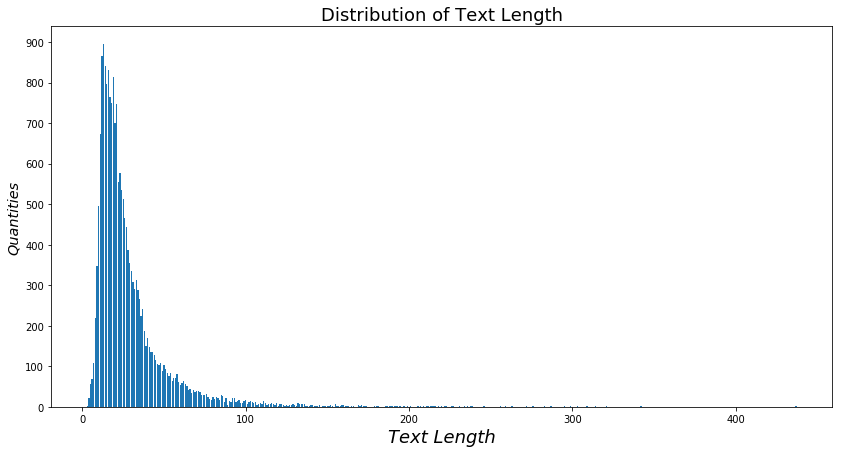

In [6]:
data['textLen'] = data['text'].str.len()
def textSnapShot(data):
    text_stats = dict(data.textLen.value_counts())
    fig, ax = plt.subplots(figsize = (14,7))
    plt.bar(text_stats.keys(),text_stats.values())
    ax.set_title('Distribution of Text Length',fontsize=18)
    ax.set_xlabel('Text Length', fontsize=18,fontstyle='italic')
    ax.set_ylabel('Quantities', fontsize='x-large',fontstyle='oblique')
    y_start, y_end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(y_start, y_end, 100))

textSnapShot(data)
del data['textLen']

In [7]:
def cleanText(string):
    p = re.compile('^\s*[?.，．.-]?[(|（|\[]?[0-9|a-zA-Z]*[)|）|\]]?\s*[、|. ．]?')
    string = p.sub('',string)

    p_1 = re.compile('^\s*[①|②|③|④|⑤|⑥|⑦|⑧|⑨|⑩|●|-]?')
    string = p_1.sub('',string)
    
    p_2 = re.compile('^\s*[⑴|⑵|⑶|⑷|⑸|⑹|⑺|⑻|⑼|⑽|⑾|⑿|⒀|⒁|⒂|⒃|⒄|⒅|⒆|⒇]?')
    string = p_2.sub('',string)
    
    string = string.replace('\xa0','').replace('&lt','<').replace('&gt','>').lower()
    string = re.sub(r"[。;；, 、（）：，]", " ", string)
    return string.strip()

data['text_copy'] = data['text']
data['text_copy'] = data['text_copy'].apply(cleanText)

In [8]:
labelEncoder = LabelEncoder()
labelEncoder.fit(data.label.tolist())
data['label'] = labelEncoder.transform(data.label.tolist())

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained(model_dir, do_lower_case=False)

In [10]:
class DataPrecessForSingleSentence(object):
    """
    对文本进行处理
    """
    def __init__(self, bert_tokenizer, max_workers=10):
        """
        bert_tokenizer :分词器
        dataset        :包含列名为'text'与'label'的pandas dataframe
        """
        self.bert_tokenizer = bert_tokenizer
        # 创建多线程池
        self.pool = ThreadPoolExecutor(max_workers=max_workers)
        # 获取文本与标签
        
    def get_input(self, dataset, max_seq_len=150):
        """
        通过多线程（因为notebook中多进程使用存在一些问题）的方式对输入文本进行分词、ID化、截断、填充等流程得到最终的可用于模型输入的序列。
        
        入参:
            dataset     : pandas的dataframe格式，包含两列，第一列为文本，第二列为标签。
            max_seq_len : 目标序列长度，该值需要预先对文本长度进行分别得到，可以设置为小于等于512（BERT的最长文本序列长度为512）的整数。
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
            labels      : 标签取值为{0~len(labels)-1}。
        
            
        """
        sentences = dataset.iloc[:, 2].tolist()
        labels = dataset.iloc[:, 1].tolist()
        # 切词
        tokens_seq = list(
            self.pool.map(self.bert_tokenizer.tokenize, sentences))
        # 获取定长序列及其mask
        result = list(
            self.pool.map(self.trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        seqs = [i[0] for i in result]
        seq_masks = [i[1] for i in result]
        seq_segments = [i[2] for i in result]
        return seqs, seq_masks, seq_segments, labels
    
    def trunate_and_pad(self, seq, max_seq_len):
        """
        1. 因为本类处理的是单句序列，按照BERT中的序列处理方式，需要在输入序列头尾分别拼接特殊字符'CLS'与'SEP'，
           因此不包含两个特殊字符的序列长度应该小于等于max_seq_len-2，如果序列长度大于该值需要那么进行截断。
        2. 对输入的序列 最终形成['CLS',seq,'SEP']的序列，该序列的长度如果小于max_seq_len，那么使用0进行填充。
        
        入参: 
            seq         : 输入序列，在本处其为单个句子。
            max_seq_len : 拼接'CLS'与'SEP'这两个特殊字符后的序列长度
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
           
        """
        # 对超长序列进行截断
        if len(seq) > (max_seq_len - 2):
            seq = seq[0:(max_seq_len - 2)]
        # 分别在首尾拼接特殊符号
        seq = ['[CLS]'] + seq + ['[SEP]']
        # ID化
        seq = self.bert_tokenizer.convert_tokens_to_ids(seq)
        # 根据max_seq_len与seq的长度产生填充序列
        padding = [0] * (max_seq_len - len(seq))
        # 创建seq_mask
        seq_mask = [1] * len(seq) + padding
        # 创建seq_segment
        seq_segment = [0] * len(seq) + padding
        # 对seq拼接填充序列
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment

In [11]:
# 类初始化
processor = DataPrecessForSingleSentence(bert_tokenizer= bert_tokenizer)
# 产生输入数据
seqs, seq_masks, seq_segments, labels = processor.get_input(dataset=data, max_seq_len=150)

In [11]:
# 加载预训练的bert模型
model = BertForSequenceClassification.from_pretrained(model_dir, num_labels= 46)

In [12]:
# 转换为torch tensor
t_seqs = torch.tensor(seqs, dtype=torch.long)
t_seq_masks = torch.tensor(seq_masks, dtype = torch.long)
t_seq_segments = torch.tensor(seq_segments, dtype = torch.long)
t_labels = torch.tensor(labels, dtype = torch.long)

train_data = TensorDataset(t_seqs, t_seq_masks, t_seq_segments, t_labels)
train_sampler = RandomSampler(train_data)
train_dataloder = DataLoader(dataset= train_data, sampler= train_sampler,batch_size = 64)

In [13]:
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [14]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 待优化的参数
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay':
        0.01
    },
    {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay':
        0.0
    }
]


# Parameters:
lr = 2e-05
max_grad_norm = 1.0
num_training_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_training_steps)  # 0.1

optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

In [15]:
# 存储每一个batch的loss
model.to(device)
loss_collect = []
for i in trange(10, desc='Epoch'):
    for step, batch_data in enumerate(tqdm_notebook(train_dataloder, desc='Iteration')):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data
        
        # 对标签进行onehot编码
        one_hot = torch.zeros(batch_labels.size(0), 46).long().to(device)
        one_hot_batch_labels = one_hot.scatter_(
            dim=1,
            index=torch.unsqueeze(batch_labels, dim=1),
            src=torch.ones(batch_labels.size(0), 46).long().to(device))
        
        
        outputs = model(batch_seqs, batch_seq_masks, batch_seq_segments, labels = batch_labels)
            
        loss,logits = outputs[:2]
        
        optimizer.zero_grad() 
        
        loss.backward()
        loss_collect.append(loss.item())
        print("\r%f" % loss, end='')
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0.490937

Epoch:  10%|█         | 1/10 [01:10<10:34, 70.47s/it]

0.463548


0.373294

Epoch:  20%|██        | 2/10 [02:26<09:38, 72.26s/it]

0.226137


0.496168

Epoch:  30%|███       | 3/10 [03:40<08:29, 72.74s/it]

0.361272


0.398563

Epoch:  40%|████      | 4/10 [04:58<07:25, 74.30s/it]

0.225080


0.169455

Epoch:  50%|█████     | 5/10 [06:12<06:11, 74.23s/it]

0.228931


0.383321

Epoch:  60%|██████    | 6/10 [07:29<05:00, 75.11s/it]

0.224382


0.336637

Epoch:  70%|███████   | 7/10 [08:43<03:43, 74.62s/it]

0.302275


0.378558

Epoch:  80%|████████  | 8/10 [10:00<02:30, 75.44s/it]

0.355998


0.255095

Epoch:  90%|█████████ | 9/10 [11:14<01:14, 74.98s/it]

0.170121


0.181293

Epoch: 100%|██████████| 10/10 [12:32<00:00, 75.21s/it]

0.310074


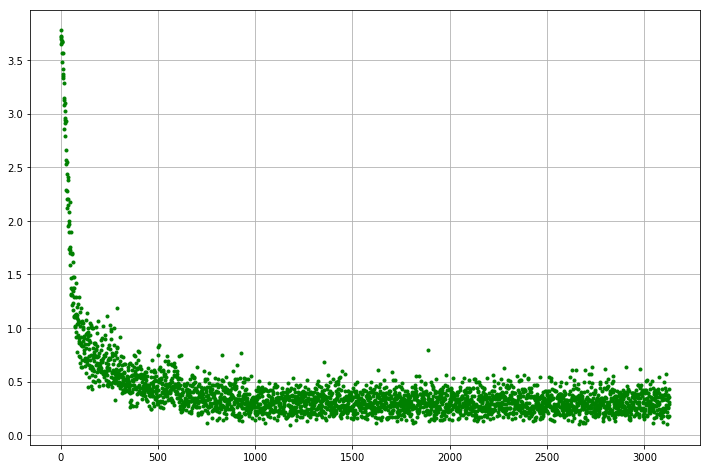

In [16]:
plt.figure(figsize=(12,8))
plt.plot(range(len(loss_collect)), loss_collect,'g.')
plt.grid(True)
plt.show()

In [17]:
torch.cuda.empty_cache()